In [1]:
import pandas as pd
import numpy as np
import missingno
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from xgboost import XGBClassifier

In [2]:
!pip install openpyxl

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


# Introduction

A customer has churned if they stop purchasing from a business, unsubscribe from a product, fail to renew a contract, etc. It is thus very sensible that businesses want to know which customers will churn. If a customer fits the profile of those who tend to churn, that customer could, for example, be targeted with an offer or information about product features that may induce them to stay. 

In this notebook, I train an XGBoost model to predict which customers will stop using services provided by a fictional telecommunications company.

Note: this is a [fictional dataset](https://www.kaggle.com/datasets/ylchang/telco-customer-churn-1113) made by IBM. One of the features Churn Score seemed likely to make the problem too easy and unrealistic, so I drop it fairly early on.

In [3]:
df_demographics = pd.read_excel('Telco_customer_churn_demographics.xlsx')
df_location = pd.read_excel('Telco_customer_churn_location.xlsx')
df_population = pd.read_excel('Telco_customer_churn_population.xlsx')
df_services = pd.read_excel('Telco_customer_churn_services.xlsx')
df_status = pd.read_excel('Telco_customer_churn_status.xlsx')


df_status.head()

,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,1,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,1,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,1,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges


In [4]:
dfs = [df_demographics, df_location, df_population, df_services, df_status]


In [5]:
for df in dfs:
    for column in df.columns:
        if 'ID' in column:
            print(column)

Customer ID
Customer ID
ID
Customer ID
Customer ID


Note most of the dataframes have a column "Customer ID" that identifies customers. The various dataframes can be joined on this column to make a single dataframe containing all of the information. For example, say we have some customer with Customer ID C. We have a row for C's demographic information in a single dataframe, a row for C's location in another dataframe, and so on. By joining multiple dataframes on this column, we create a single dataframe with a row for C that contains all of C's information from the various dataframes.

I perform further examination to determine what the ID column is and if it is identical to Customer ID

In [6]:
for df in dfs:
    print(df.shape)

(7043, 9)
(7043, 9)
(1671, 3)
(7043, 30)
(7043, 11)


We can see above that the population dataframe has fewer rows than the rest.

In [7]:
df_population

,ID,Zip Code,Population
0,1,90001,54492
1,2,90002,44586
2,3,90003,58198
3,4,90004,67852
4,5,90005,43019
...,...,...,...
1666,1667,96145,4002
1667,1668,96146,942
1668,1669,96148,678
1669,1670,96150,33038


This is a dataframe with zipcodes and associated populations. We can join this to a dataframe containing zip code information once we know other columns with the Zip Code feature, then ignore the df_population dataframe going forwards. Further, I do not want this ID column. It is duplicative of the index.

In [8]:
for i, df in enumerate(dfs):
    if 'Zip Code' in df:
        print(i+1)

2
3


The Zip Code feature is sensibly also in the df_location dataframe. I join the population dataframe to that one and ignore the df_population dataframe from now on.

In [9]:
df_population.drop('ID', axis=1, inplace=True)
df_location= df_location.merge(df_population, how='inner', on='Zip Code')
dfs = [df_demographics, df_location, df_services, df_status]

In [10]:
dfs_reindexed = []
for df in dfs:
    if 'Customer ID' in df.columns:
        dfs_reindexed.append(df.set_index('Customer ID').sort_index())
    else:
        df.set_index('ID', inplace=True)
        df.index.rename('Customer ID', inplace=True)
        dfs_reindexed.append(df.sort_index())

In [11]:
(df_demographics['Count'] ==df_services['Count']).all()

True

We next need to remove overlapping columns, i.e. columns that are present in both dataframes. In order to do so properly, we must make sure that columns overlap in their content rather than just in their names.

In [12]:
column_counts = {}
# Find how many dataframes each column appears in
for df in dfs_reindexed:
    for col in df.columns:
        if col not in column_counts:
            column_counts[col] = 1
        else:
            column_counts[col] += 1

# Remove columns only in a single dataframe from the dictionary
column_counts = {col_name:column_counts[col_name] for col_name in column_counts.keys() if column_counts[col_name] > 1}
column_counts

{'Count': 4, 'Quarter': 2}

There are three columns in multiple dataframes. Count is in 4 dataframes. Zip Code and Quarter are both in 2 dataframes.

In [13]:
overlap_dfs = {col_name: [] for col_name in column_counts}
for col in column_counts:
    for df in dfs_reindexed:
        if col in df.columns:
            overlap_dfs[col].append(df)

for col in overlap_dfs:
    col_dfs = overlap_dfs[col]
    same_content = []
    base_df = col_dfs[0]
    for other_df in col_dfs[1:]:
        # Appends true if the column in question is identical in all dataframes in which it occurs
        same_content.append((other_df[col] == base_df[col]).all())

same_content


[True]

The overlapping columns are in fact overlapping in substance and not just in title. So I drop the columns in all but one dataframe in which they are in place.

In [14]:
for col in overlap_dfs:
    for df in overlap_dfs[col][1:]:
        df.drop(col, axis=1, inplace=True)

In [15]:
dfs_reindexed[0].merge(dfs_reindexed[3], on='Customer ID')

,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
Customer ID,,,,,,,,,,,,,,,,
0002-ORFBO,1,Female,37,No,No,Yes,No,0,3,Stayed,No,0,65,2205,NaN,NaN
0003-MKNFE,1,Male,46,No,No,No,No,0,5,Stayed,No,0,66,5414,NaN,NaN
0004-TLHLJ,1,Male,50,No,No,No,No,0,1,Churned,Yes,1,71,4479,Competitor,Competitor had better devices
0011-IGKFF,1,Male,78,No,Yes,Yes,No,0,1,Churned,Yes,1,91,3714,Dissatisfaction,Product dissatisfaction
0013-EXCHZ,1,Female,75,No,Yes,Yes,No,0,1,Churned,Yes,1,68,3464,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9987-LUTYD,1,Female,20,Yes,No,No,No,0,4,Stayed,No,0,59,3161,NaN,NaN
9992-RRAMN,1,Male,40,No,No,Yes,No,0,1,Churned,Yes,1,68,5248,Dissatisfaction,Product dissatisfaction
9992-UJOEL,1,Male,22,Yes,No,No,No,0,5,Joined,No,0,33,5870,NaN,NaN


In [16]:
df = dfs_reindexed[0].join(dfs_reindexed[1:])
df.head()

,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
Customer ID,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,1,Female,37,No,No,Yes,No,0,United States,California,...,381.51,974.81,3,Stayed,No,0,65,2205,NaN,NaN
0003-MKNFE,1,Male,46,No,No,No,No,0,United States,California,...,96.21,610.28,5,Stayed,No,0,66,5414,NaN,NaN
0004-TLHLJ,1,Male,50,No,No,No,No,0,United States,California,...,134.60,415.45,1,Churned,Yes,1,71,4479,Competitor,Competitor had better devices
0011-IGKFF,1,Male,78,No,Yes,Yes,No,0,United States,California,...,361.66,1599.51,1,Churned,Yes,1,91,3714,Dissatisfaction,Product dissatisfaction
0013-EXCHZ,1,Female,75,No,Yes,Yes,No,0,United States,California,...,22.14,289.54,1,Churned,Yes,1,68,3464,Dissatisfaction,Network reliability


# Dropping Undesired or Useless Features

## Drop Columns with Only One Value
If a feature can only take one value, it can never be useful in distinguishing classes. Such features are removed.

In [17]:
uniform_features = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(f'There is only 1 unique value in the {col} feature')
        uniform_features.append(col)

df.drop(uniform_features, axis=1, inplace=True)

There is only 1 unique value in the Count feature
There is only 1 unique value in the Country feature
There is only 1 unique value in the State feature
There is only 1 unique value in the Quarter feature


## Dropping Undesired Features

There are two features that I do not want.

Lat Long simply contains latitude and longitude as a tuple. So it contains information in other features, just in a less convenient score.

Churn Score is a value that is higher the more likely a customer is to churn, according to the dataset description. The dataset description claims it was calculated by Watson. I remove this feature to make the problem more realistic.

In [18]:
df.drop(['Lat Long', 'Churn Score'], axis=1, inplace=True)

## Potentially Duplicative Features
We have the features Customer Status, Churn Label, and Churn Value. Customer Status  says whether a customer has stayed, joined, or churned and the latter two features say whether a feature has churned. I check to see whether any customer has just joined and also churned and also whether Churn Label and Churn Value are identical.

In [19]:
join_and_churn = df[(df['Customer Status'] == 'Joined') & (df['Churn Label'] == 'Yes')]
if len(join_and_churn) == 0:
    print('There are no customers that both just joined and churned')

There are no customers that both just joined and churned


In [20]:
churn_label_value_identical = (pd.get_dummies(df['Churn Label'], drop_first=True)['Yes'] == df['Churn Value']).all()
if churn_label_value_identical == True:
    print('Churn Label and Churn Value are identical')

Churn Label and Churn Value are identical


Since Churn Label and Churn Value are identical, I drop Churn Label and retain Churn Value, the feature that is already integer encoded. Similarly, the 'Customer Status' feature provides no new information, so it is also dropped.

In [21]:
df.drop(['Churn Label', 'Customer Status'], axis=1, inplace=True)

# Examining Missing Values
It is useful to figure out what features have missing values and how many. To visualize this, I use the Missingno library. This allows me to plot a bar chart, with a bar for each feature and the height of the bar representing the number of values present for each feature.

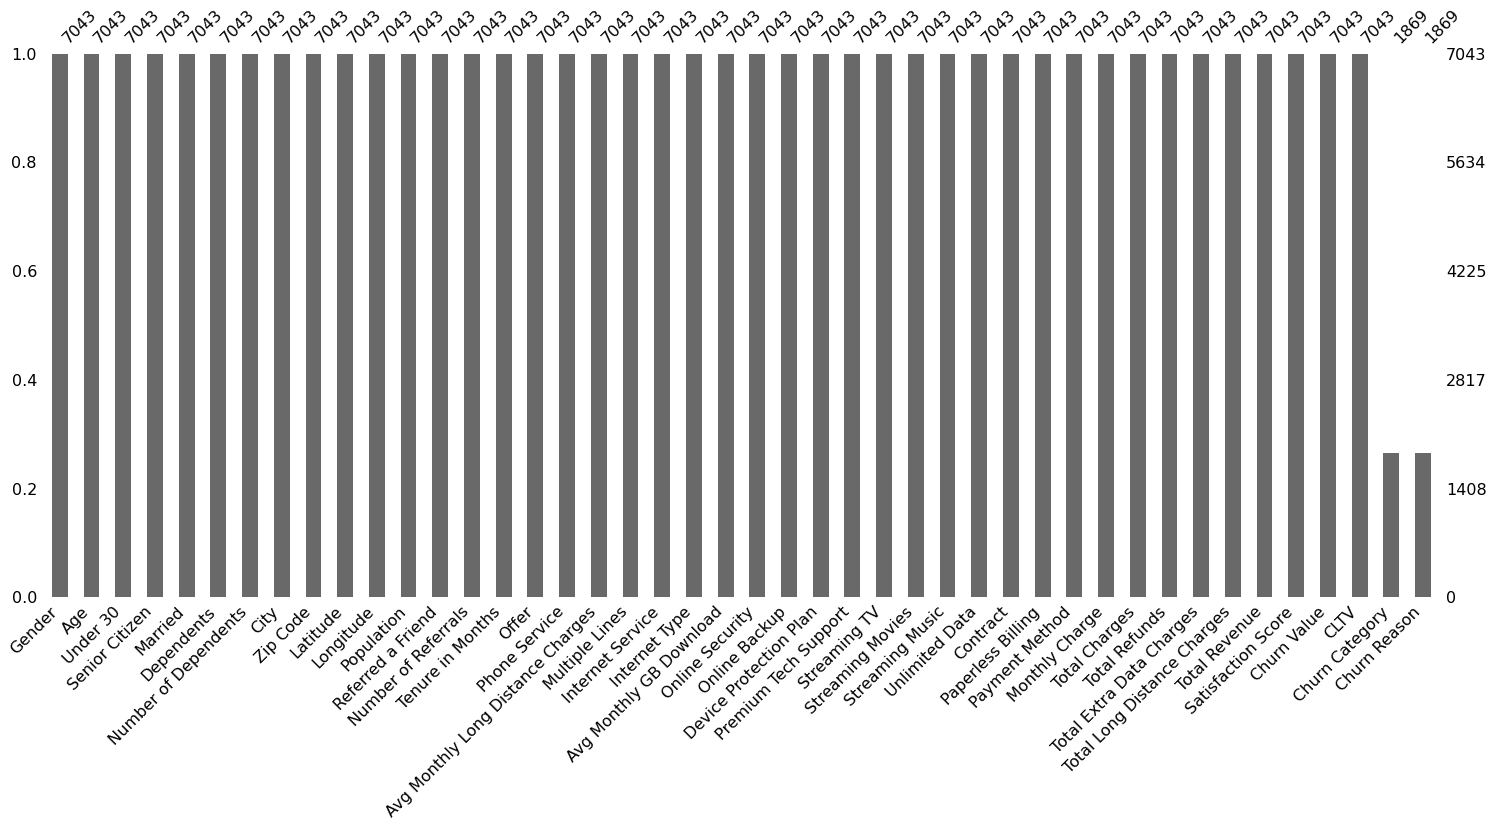

In [22]:
missingno.bar(df)
plt.show()

We see above that there are only values missing in Churn Category and Churn Reason. While these features are potentially interesting - it could be interesting to predict why a customer will leave, not just whether they will, almost 80% of the data is missing, so I drop the features rather than trying to impute values.

In [23]:
df.drop(['Churn Category', 'Churn Reason'], axis=1, inplace=True)

# Exploratory Data Analysis
Below, I visualize the data and calculate summary statistics for numerical variables.

## Splitting Data into Numerical and Categorical
The numerical and categorical features must be visualized differently. Thus, it is convenient to know which variables are categorical and which are numerical.

In [24]:
df.dtypes

Gender                                object
Age                                    int64
Under 30                              object
Senior Citizen                        object
Married                               object
Dependents                            object
Number of Dependents                   int64
City                                  object
Zip Code                               int64
Latitude                             float64
Longitude                            float64
Population                             int64
Referred a Friend                     object
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download                int64
Online Sec

A good rough first approximation of splitting categorical and numerical data is to treat object variables as categorical and numerical variables as numerical. This, however is insufficient. There's no numerical relationship bewteen zip codes (at least not in the sense that it makes sense to say "the zip code 90210 is greater than the zip code 90200), so the zip codes are also categorical. Churn Value is also categorical, since it is a boolean feature.

In [25]:
numerical = []
categorical = []
for column in df.columns:
    if df[column].dtype == object or column == 'Zip Code' or column == 'Churn Value':
        categorical.append(column)
    else:
        numerical.append(column)

### Numerical Variable Distributions

### Summary Statistics and Quartiles
Below is a table of useful information about each numerical variable. The table contains the mean, standard deviation, minimum and maximum and 25%, 50% and 75% quartile for each.

In [26]:
df[numerical].describe()

,Age,Number of Dependents,Latitude,Longitude,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,CLTV
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,36.197455,-119.756684,22139.603294,1.951867,32.386767,22.958954,20.515405,64.761692,2280.381264,1.962182,6.860713,749.099262,3034.379056,3.244924,4400.295755
std,16.750352,0.962802,2.468929,2.154425,21152.392837,3.001199,24.542061,15.448113,20.418940,30.090047,2266.220462,7.902614,25.104978,846.660055,2865.204542,1.201657,1183.057152
min,19.000000,0.000000,32.555828,-124.301372,11.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000,1.000000,2003.000000
25%,32.000000,0.000000,33.990646,-121.788090,2344.000000,0.000000,9.000000,9.210000,3.000000,35.500000,400.150000,0.000000,0.000000,70.545000,605.610000,3.000000,3469.000000
50%,46.000000,0.000000,36.205465,-119.595293,17554.000000,0.000000,29.000000,22.890000,17.000000,70.350000,1394.550000,0.000000,0.000000,401.440000,2108.640000,3.000000,4527.000000
75%,60.000000,0.000000,38.161321,-117.969795,36125.000000,3.000000,55.000000,36.395000,27.000000,89.850000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,4.000000,5380.500000
max,80.000000,9.000000,41.962127,-114.192901,105285.000000,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,5.000000,6500.000000


### Univariate Distributions

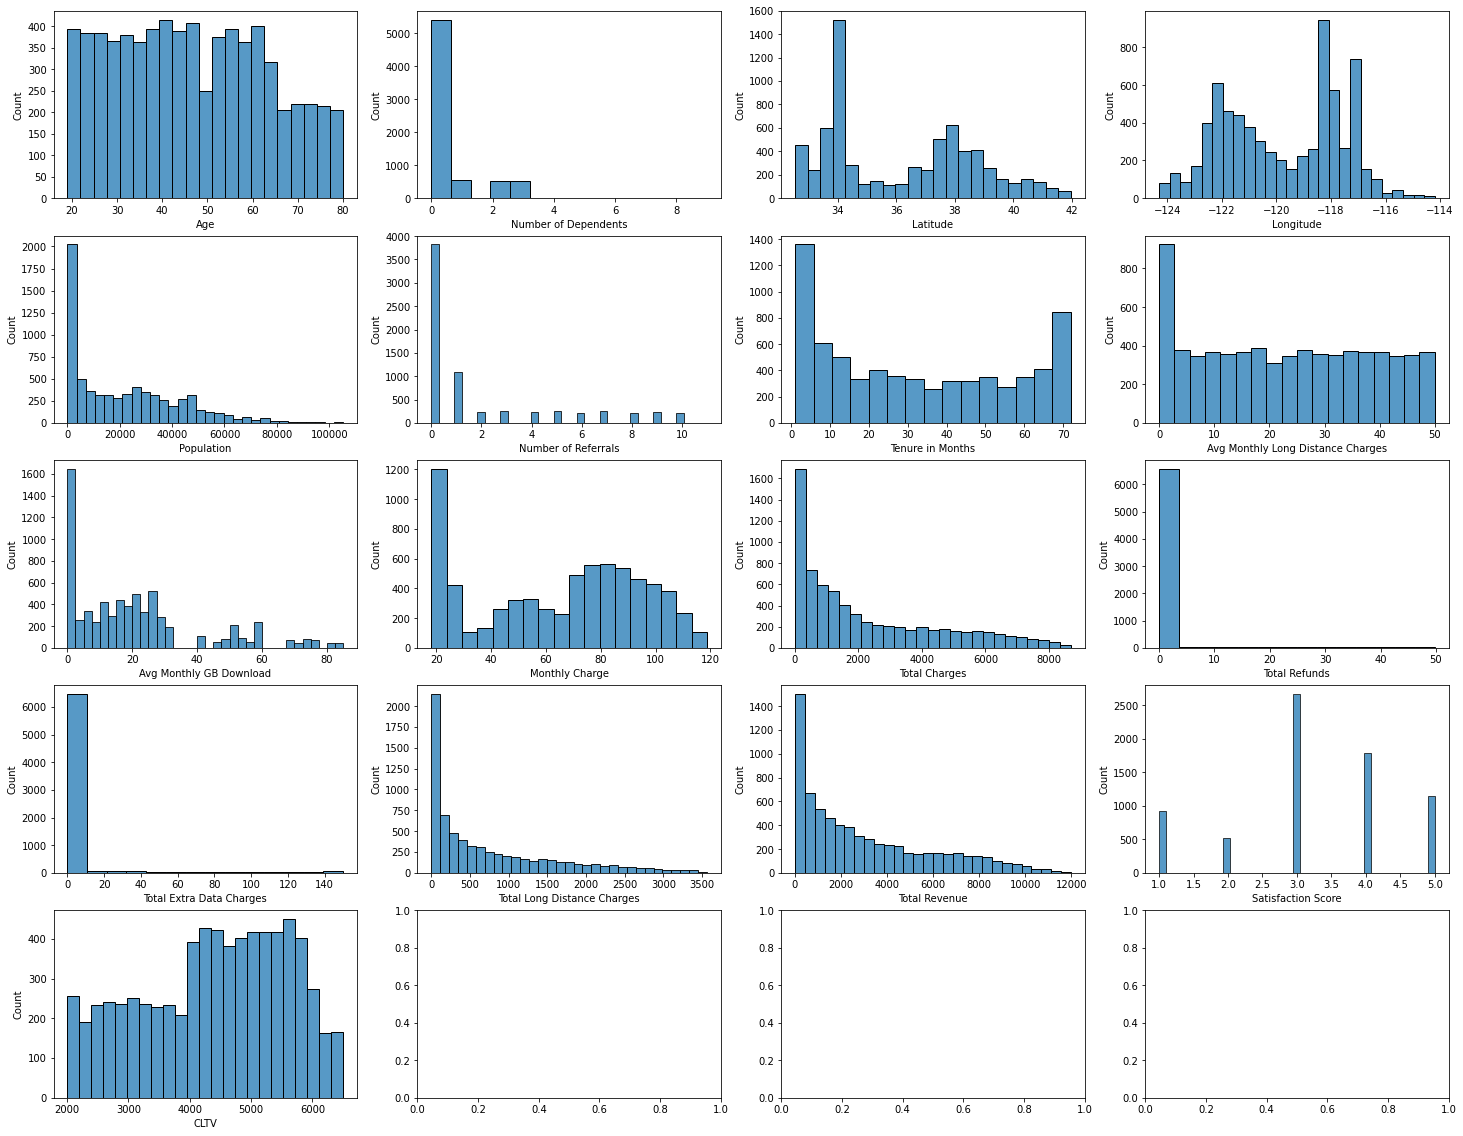

In [27]:
fig, axes = plt.subplots(5, 4, figsize=(25,20))

for i, (ax, col) in enumerate(zip(np.ravel(axes), df[numerical].columns)):
    sns.histplot(data=df[numerical], x=col, ax=ax)

### Bivariate Distributions
Here, each feature is plotted against the target variable as a violin plot. A violin plot estimates the density of the feature in question. In addition, quartiles are plotted on each distribution. The longer dashed line is the median, the 50% quartile. The lower dashed line is the 25% quartile and the higher line is the 75% quartile.

Take, for example, the Tenure in Months feature. The density of customers who churned is higher for a low number of months and narrows as the number of months decreases. The density is relatively more evenly distributed for customers who did not churn. Consider next Total Long Distance Charges. While the two density estimates differ, it is also plain to see that the median value is higher for customers who did not churn than for customers who did.

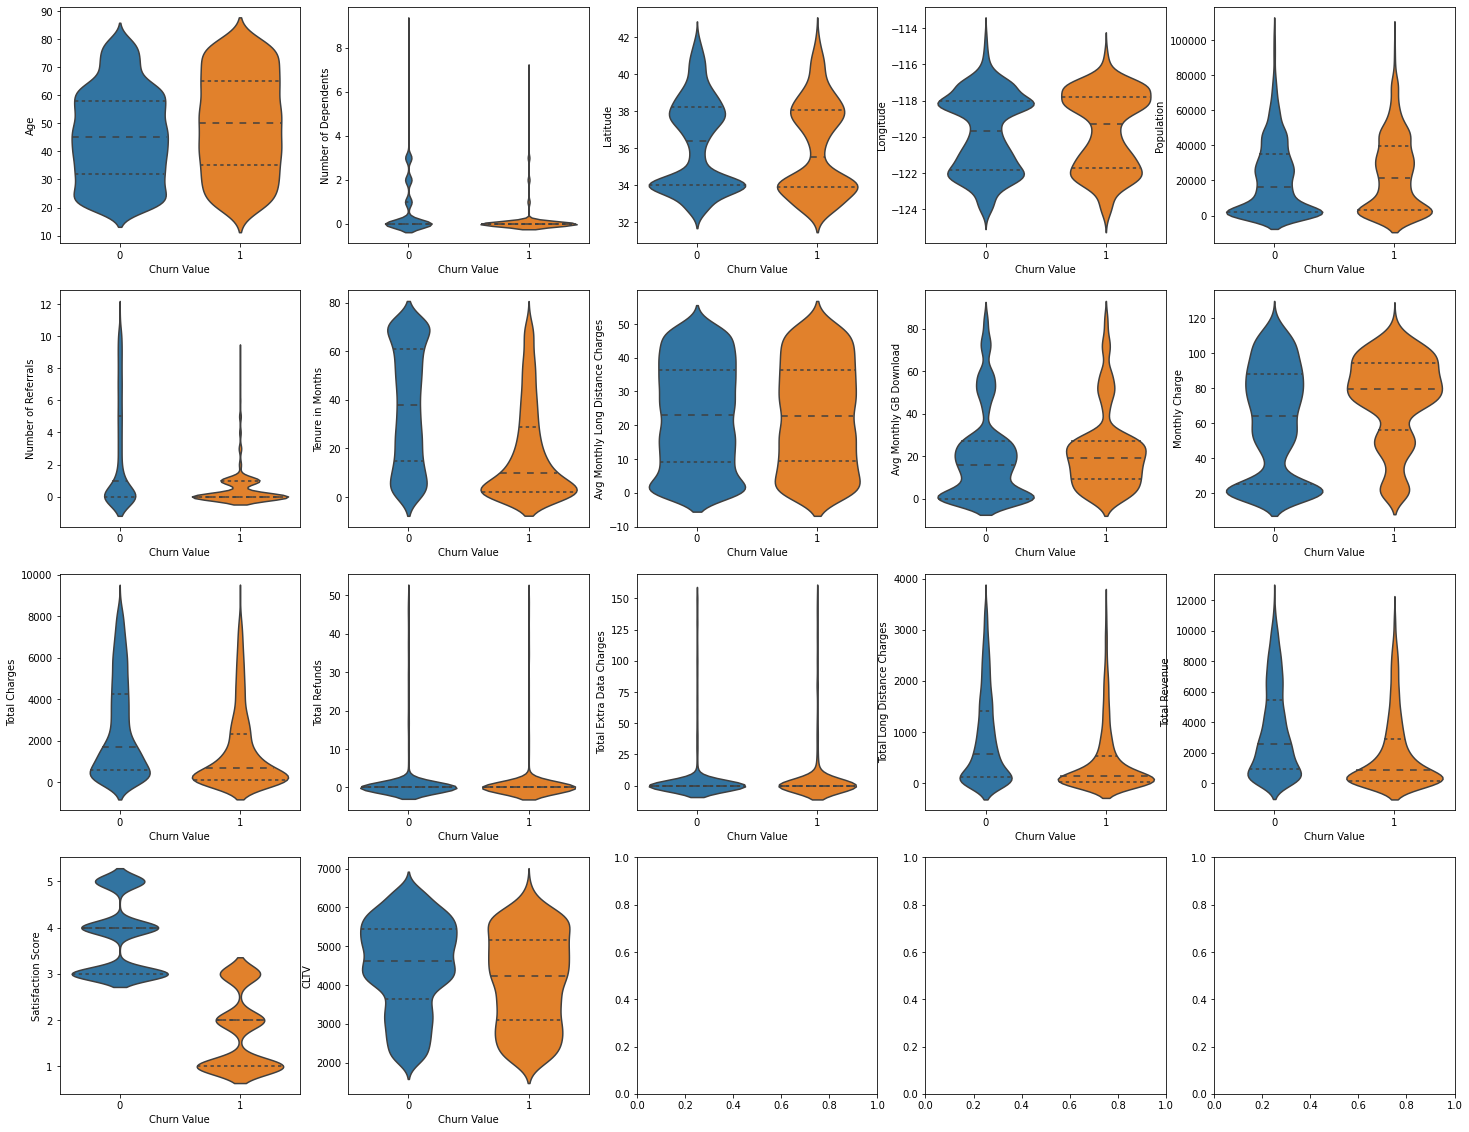

In [28]:
fig, axes = plt.subplots(4, 5, figsize=(25,20))

for i, (ax, col) in enumerate(zip(np.ravel(axes), df[numerical].columns)):
    sns.violinplot(data=df[numerical],  x=df['Churn Value'], y=col, inner='quartile', ax=ax)

Many of the distributions look similar for the two values of Churn Value, but Monthly Charge and Satisfaction Score stand out. Specifically, about 3/4 customers who churned had a Monthly Charge of 60 or above. About 50% of them had a Monthly Charge of 80 or above. In constrast, almost 75% of customers who stayed had a Monthly Charge of 80 or below.

The Satisfaction Score is even more stark. All of the customers with Satisfaction Scores of 1 or 2 churned, but none of the customers with Satisfaction Scores of 4 or 5 churned. Clearly, the company should keep obtaining information about customer satisfaction. Additionally, it may want to consider running an A/B tests aimed at retaining unsatisfied customers or targeting unsatisfied customers.

### Categorical Variables

Given the values would have to be one-hot encoded to treat values in the Zip Code and CIty features categorically, which would be expensive and make training more difficult, and that location information is present in other features, I drop the City and Zip Code features.

In [30]:
df.drop(['City', 'Zip Code'], axis=1, inplace=True)
categorical.remove('City')
categorical.remove('Zip Code')

### Univariate Plots

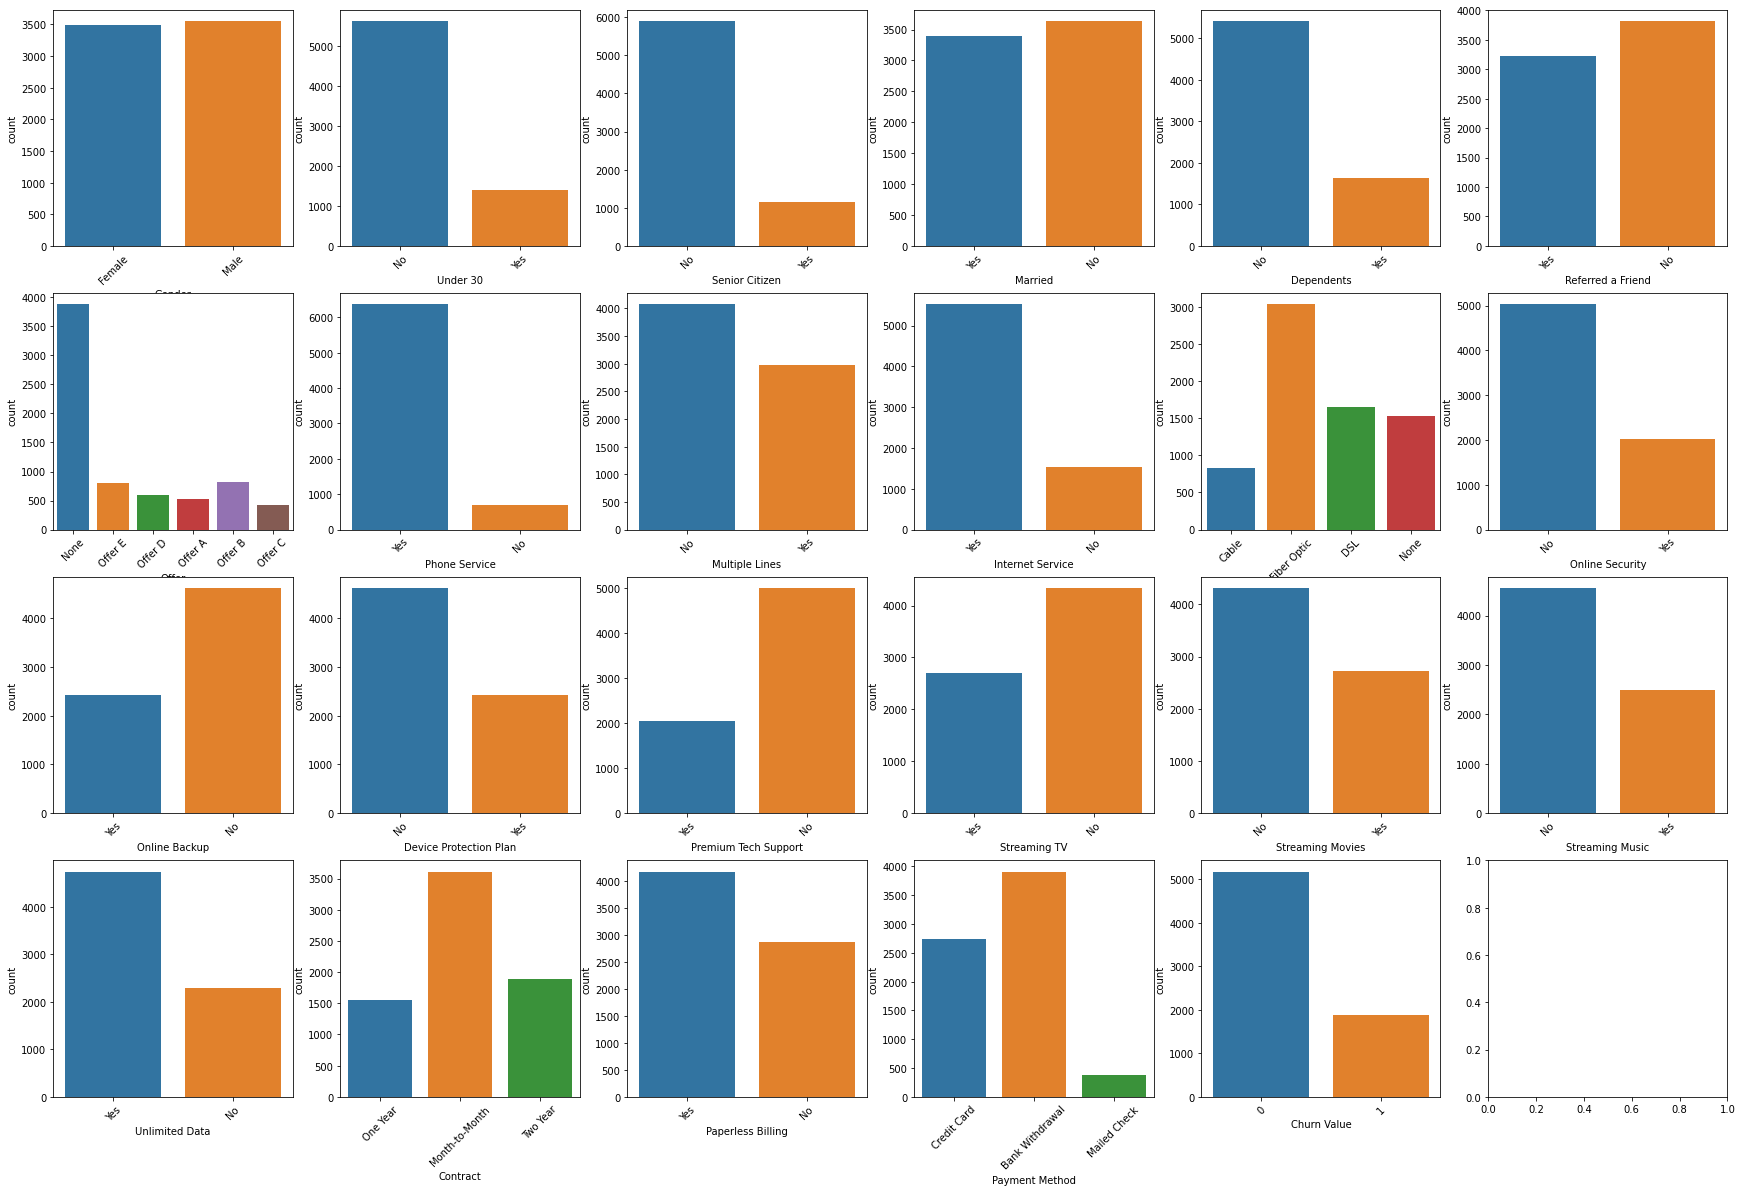

In [31]:
fig, axes = plt.subplots(4, 6, figsize=(30,20))

for i, (ax, col) in enumerate(zip(np.ravel(axes), df[categorical].columns)):
    sns.countplot(data=df[categorical], x=col, ax=ax)
    ax.tick_params(axis='x', rotation=45)

Note above that Churn Value is imbalanced. However, the imbalance is not too severe, with about 2000 customers who churned vs 5000 who did not. This should not require any methods to account for the imbalance.

To avoid problems when encoding variables later, no categorical values should be the same in different features. Here, 'None' is a possible value both for the Offer and the Internet Type feature. To remedy this, I replace the 'None' value in Offer with 'No Offer'.

In [32]:
df['Offer'].replace(to_replace='None', value='No Offer', inplace=True)

### Bivariate Plots

To get the plots of categorical features broken out by the Churn Value, it is ideal to work not with counts but percentages. For example, it would be nice to know not just what number of men churned compared to men who did not churn but what portion of people who churned were men compared to the portion of people who did not. Visually, this means we can compare the heights of the bars without having to mentally correct for the fact that fewer people churned. I show an example below of a dataframe after calculating percentages.

In [33]:
def churn_percentage_by_category(category):
    df_category_percentages = df[categorical].groupby([category, 'Churn Value']).count().reset_index(level=['Churn Value'])
    num_churn = len(df[df['Churn Value'] == 1])
    num_stay = len(df) - num_churn
    df_category_percentages[df_category_percentages['Churn Value'] == 1] = df_category_percentages[df_category_percentages['Churn Value'] == 1] / num_churn
    df_category_percentages[df_category_percentages['Churn Value'] == 0] = df_category_percentages[df_category_percentages['Churn Value'] == 0] / num_stay
    df_category_percentages['Churn Value'] *= num_churn
    df_category_percentages['Churn Value'] = df_category_percentages['Churn Value'].round(0).astype(int)
    split_col = df_category_percentages.columns[1]
    return df_category_percentages.reset_index(), split_col

df_perc, split_col = churn_percentage_by_category('Gender')
df_perc

,Gender,Churn Value,Under 30,Senior Citizen,Married,Dependents,Referred a Friend,Offer,Phone Service,Multiple Lines,...,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method
0,Female,0,0.492656,0.492656,0.492656,0.492656,0.492656,0.492656,0.492656,0.492656,...,0.492656,0.492656,0.492656,0.492656,0.492656,0.492656,0.492656,0.492656,0.492656,0.492656
1,Female,1,0.502408,0.502408,0.502408,0.502408,0.502408,0.502408,0.502408,0.502408,...,0.502408,0.502408,0.502408,0.502408,0.502408,0.502408,0.502408,0.502408,0.502408,0.502408
2,Male,0,0.507344,0.507344,0.507344,0.507344,0.507344,0.507344,0.507344,0.507344,...,0.507344,0.507344,0.507344,0.507344,0.507344,0.507344,0.507344,0.507344,0.507344,0.507344
3,Male,1,0.497592,0.497592,0.497592,0.497592,0.497592,0.497592,0.497592,0.497592,...,0.497592,0.497592,0.497592,0.497592,0.497592,0.497592,0.497592,0.497592,0.497592,0.497592


Above, the first column in the dataframe is the column of interest. The second column is the churn value. The remaining columns are the percentage of people broken out by the first two columns. We can use any of these remaining columns to represent the height of the bars in a bar plot. I use the first column and refer to that as split_col.

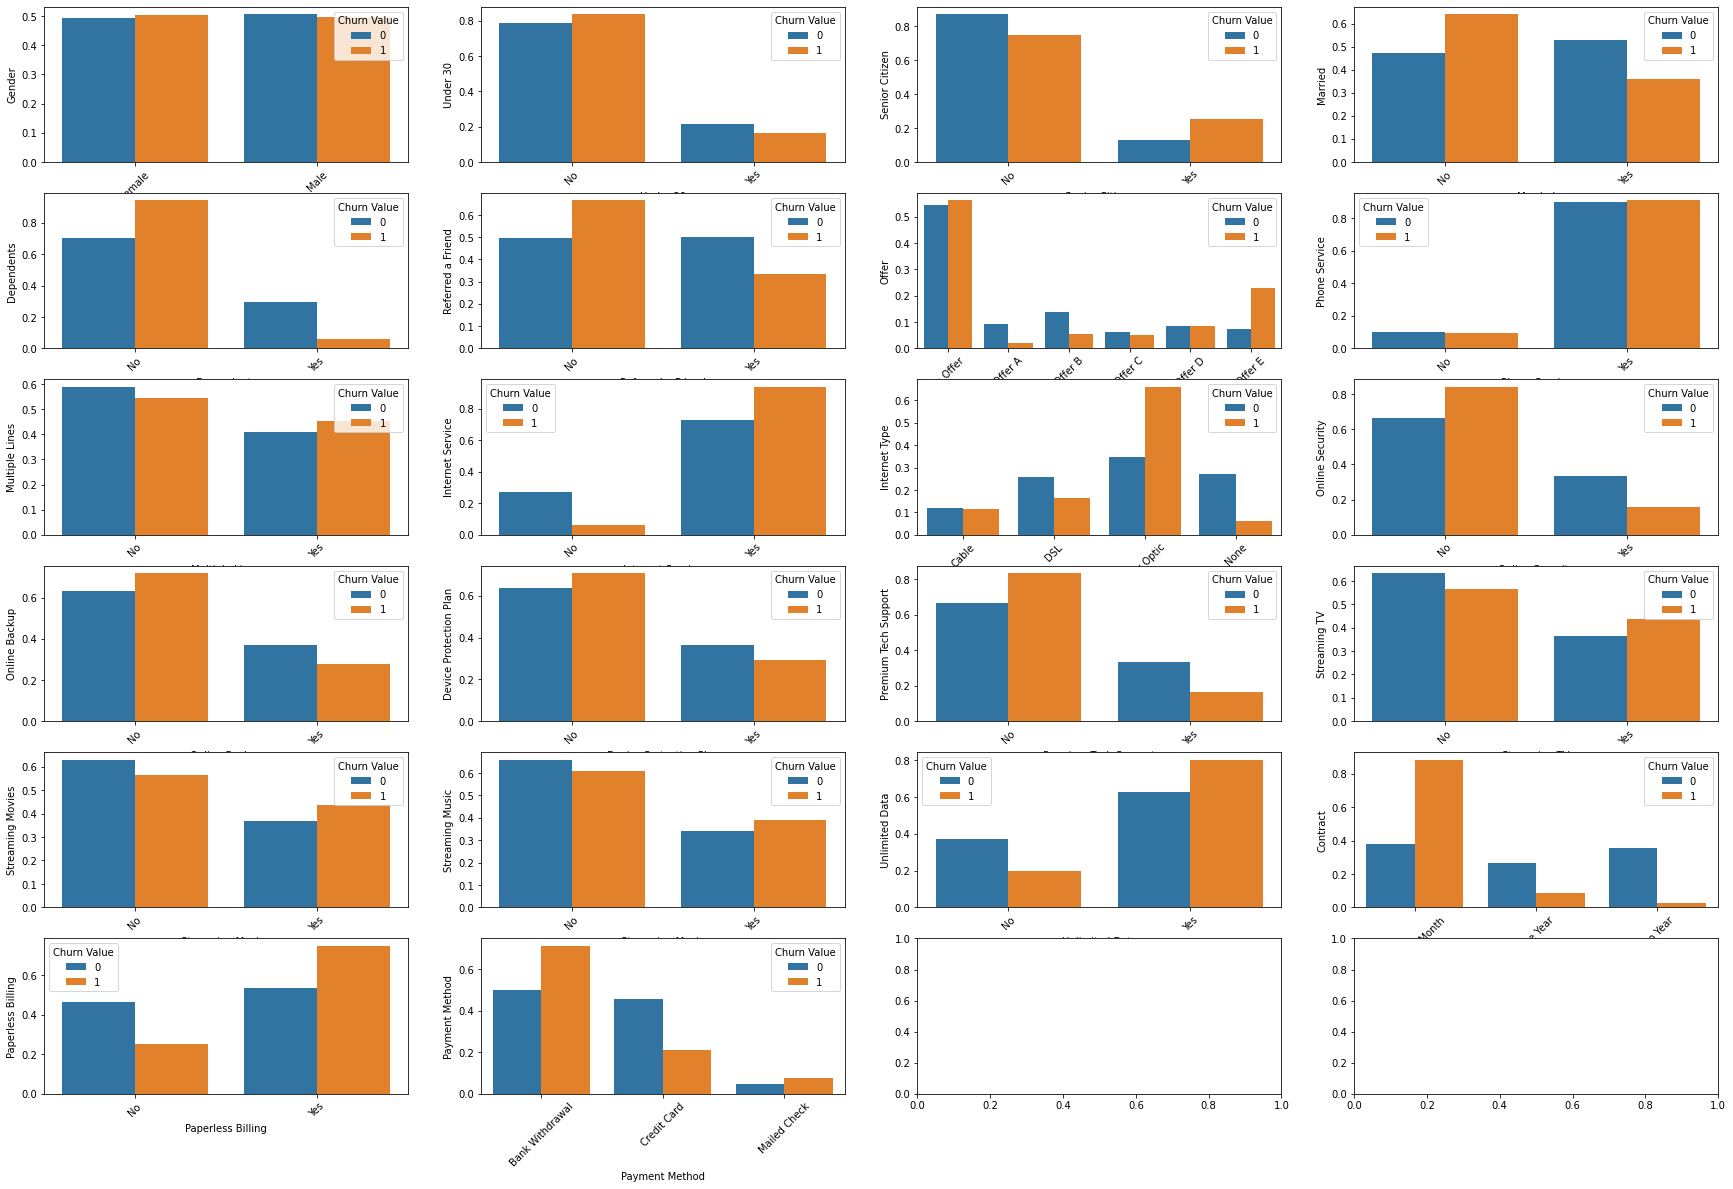

In [34]:
fig, axes = plt.subplots(6, 4, figsize=(30,20))

for i, (ax, col) in enumerate(zip(np.ravel(axes), df[[feat for feat in categorical if feat != 'Churn Value']].columns)):
    df_perc, split_col = churn_percentage_by_category(col)
    sns.barplot(data=df_perc, x=col, y=split_col, hue='Churn Value', ax=ax)
    ax.set_ylabel(col)
    ax.tick_params(axis='x', rotation=45)

Since the bar heights are now normalized, we can now quickly see whether values of variables are over or underrepresented for customers who churned compared to those who did not. The trade off is that we lose information about whether more customers churned or not, but we have that information elsewhere.

Consider, for example, the Offer feature. Customers who churned were more likely to receive Offer E but more likely to have received Offer A. Consider next the Contract feature. It is substantially more likely that a customer who churned had a monthly contract than a customer who stayed. All of the features can be analyzed this way.

# Encode and Split Data
In order for the model to appropriately handle categorical features, those features must be encoded. If you consider a categorical variable that takes the values [A, B, C], you can imagine (at least) two ways to encode the variable. First, you could encode the variable such that A=0, B=1, C=2. But this would encode a numerical relationship between values, and leave the feature indistinguishable from something like the Number of Dependents. In otherwords, the model would treat the feature as if A + B = B, B * 2 = C, but these may not be reflected by the actual feature.

The second and preferred way to encode the feature is to create a feature called A that takes the values [0,1] and another feature for B that takes the values [0,1]. If the categorical variable takes the value A, then the encoded features take the values A=1, B=0 and similarly for B. If the variable takes the value C, then A=0 and B=0. This encodes the variable properly, but it does introduce a large number of new variables. Specifically, for every categorical variable, it adds a number of features equivalent to the number of unique values the variable can take minus one.

The data is also split below. To test the performance of the model, some data must be held out. The model is not trained on this data, called the test set. It is training on the remaining data, called the training set. You can imagine the training data as representing some signal (which generalizes) and some noise (unique to the training set). We train and test on other sets to get an idea of how the model makes predictions on the new data. Testing on the training set will give overly optimistic performance metrics because the model will fit to the particularities of the training set. In splitting the data, care is taken to ensure that churning customers are equally represented in the training and test sets.

In [35]:
cat_features = list(df.columns)


In [37]:
df_cat_encode = df[cat_features].copy()
for column in categorical:
    if column in cat_features:
        if column != 'Churn Value':
            if len(df_cat_encode[column].unique()) == 2:
                df_cat_encode[column] = pd.get_dummies(df_cat_encode[column], drop_first=True)
            else:
                dummies = pd.get_dummies(df_cat_encode[column], drop_first=True)
                df_cat_encode = pd.concat([df_cat_encode, dummies], axis=1)
                df_cat_encode.drop(column, axis=1, inplace=True)
df_cat_encode.head()

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Population,Referred a Friend,Number of Referrals,...,Offer C,Offer D,Offer E,DSL,Fiber Optic,None,One Year,Two Year,Credit Card,Mailed Check
Customer ID,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,0,37,0,0,1,0,0,4498,1,2,...,0,0,0,0,0,0,1,0,1,0
0003-MKNFE,1,46,0,0,0,0,0,31297,0,0,...,0,0,0,0,0,0,0,0,1,0
0004-TLHLJ,1,50,0,0,0,0,0,62069,0,0,...,0,0,1,0,1,0,0,0,0,0
0011-IGKFF,1,78,0,1,1,0,0,46677,1,1,...,0,1,0,0,1,0,0,0,0,0
0013-EXCHZ,0,75,0,1,1,0,0,42853,1,3,...,0,0,0,0,1,0,0,0,1,0


In [39]:
y = df_cat_encode.pop('Churn Value')
x = df_cat_encode

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=123)

# Model Training

I use XGBoost to make predictions. The advantages of XGBoost are best explained by first explaining decision trees and then explaining gradient boosting. 

A typical decision tree works as follows in training to solve a classification problem. The tree starts with some data and labels. The tree considers various values of various feature to determine how to best split the data. The data is split about the chosen value into two subsets, those with samples where the value of the feature is higher than the splitting point and those where the value of the feature is lower. The goodness of the split is determined by looking at some metric, like an impurity score. The point at which the model splits the data is a node. The model continuously splits the data until the tree reaches some set depth or until it has perfectly classified everything.

The decision tree trains very quickly and makes no assumptions about the data, thus it requires very little data preprocessing. However, it can very easily fit the data perfectly, thus overfitting. Generally, for some dataset, the decision tree will make very different predictions when trained on different subsets of the data, making it high variance.

Gradient boosting addresses decision tree's variance problem by using an ensemble of trees. Rather than training a single tree, multiple relatively weak (i.e. short) trees are trained and the resulting classifier is a weighted sum of all of these trees. However, each tree is not trained on the same dataset. Gradient boosting treets classification as a regression problem. The first tree makes some constant guess (usually the log odds of the ground truth labels) then each subsequent tree is trained on the residuals from the prior tree. The overall classifier is the weighted sum of all of the trees. Conceptually, since each subsequent tree is adding (an estimate off) the residual from the previous tree to the overall prediction, this can be thought of as gradient descent. Thus the tree weights are like the learning rate.

XGBoost improves on gradient boosting. It still uses weak trees to estimate the residuals from previous trees. But by expanding the loss function as a second order Taylor series, in addition to making some otherwise intractable problems solvable, it gains access to second order "gradients" and trains much more quickly. In addition,  XGBoost contains built in regularization parameters in its loss function approximation, which gradient boost does not. A full discussion of XGBoost, including its derivation, can be found in the associated paper [here](https://arxiv.org/abs/1603.02754).

I do an initial fitting of the model to get a rough idea of its performance.

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1040
           1       0.93      0.94      0.93       369

    accuracy                           0.96      1409
   macro avg       0.95      0.96      0.95      1409
weighted avg       0.96      0.96      0.96      1409



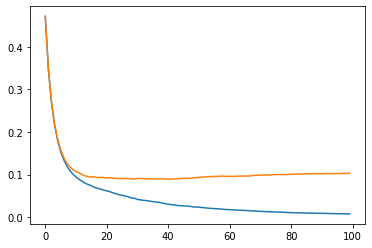

In [40]:
xgboost = XGBClassifier()
eval_data = [(x_train, y_train), (x_test, y_test)]
xgboost.fit(x_train, y_train, eval_set=eval_data, verbose=0)
train_results = xgboost.evals_result()

# plot results
epochs = range(len(train_results['validation_0']['logloss']))
sns.lineplot(x=epochs, y=train_results['validation_0']['logloss'])
sns.lineplot(x=epochs, y=train_results['validation_1']['logloss'])

# Evaluate
y_hat = xgboost.predict(x_test)
print(classification_report(y_hat, y_test))

This already looks pretty good. But depending on the application, we may be more interested in detecting customers who will churn than customers who will not. Suppose the application of the model is to send materials (ex. promotional offers) to customers at risk of churning. It could be better to send the offers to customers who would not churn than to lose more customers by not sending them offers. In addition, the model begins to overfit. The loss on the training set continues to go down, but the loss on the test set eventually begins to increase. Put simply, the model begins to learn things in the training set that are not in the unseen data, so its ability to make predictions based on new data decreases as it trains. 


## Cross Validation

To attempt to improve performance, I will perform a grid search over hyperparameters with the intent of optimizing the f1-score on churning customers.

If every combination of some sets of parameters is a grid, then a grid search simply trains the model for every point on the grid. However, the model may perform better on one subset of the data than another. Extending from that, the model may perform better on the training data than on any unseen data. To prevent this, five fold cross validation is performed for every combination of hyperparameters. Five fold cross validation proceeds as follows: first, the data is split into five parts. The model is trained on four of the subsets of the data combined, and the f1-score for the churning customers is calculated on the fifth. Then the model is trained on four other subsets of the data and a second fifth is used to evaluate the model. This continues until all of the data has been used to test the model. So in a simple case with four combinations of hyperparameters, the model will be trained 20 times, five times for each combinations of hyperparameters. For each combination of hyperparameters, all of the evaluation scores are averaged. To the extent that the model has fit to noise in the various subsets of the data, this is averaged out by the averaging process. Returning to the simple example, the grid search process would end by returning four scores, one for each set of hyperparameters. The set of hyperparameters with the highest associated score is the best out of all of the combinations of hyperparameters that were tried.

Since the model has to be retrained so many times, the grid search process is slow. However, for any given dataset, the process only has to happen once, so it will only ever benefit the end user of the model.

### Parameters

I tune three parameters, eta, gamma and the maximum tree depth. The model is a weighted sum of weak learners, each fitting to the residuals from the previous learner. Eta is the weight associated with each learner, essentially a learning rate. A higher Eta puts more significance on the learners and a lower Eta less. Gamma controls automatic pruning. A higher value of gamma will lead to the model pruning more nodes, and thus using simpler learners, and lower gamma will prune fewer nodes. This is essentially a regularization parameter to prevent overfitting. The max depth is the maximum depth of the tree. A deeper tree can better model the dataset, but it may model it too well, fitting to noise failing to generalize. A tree that is not deep enough cannot model the dataset well at all.

In [41]:
eta_range = np.linspace(0.001,.3,10) # shrinkage parameter for weighted sum
max_gamma_range = [10**x for x in np.linspace(-3,-1, 3)] # Minimum loss decrease to make a new node
max_depth_range = np.linspace(3,8, 6, dtype=int) # deepest allowed tree

params = {'eta':eta_range, 'gamma':max_gamma_range, 'max_depth':max_depth_range}
clf = XGBClassifier(n_estimators=200)
f1_scorer = make_scorer(f1_score, labels=1)
gs = GridSearchCV(clf, params, scoring=f1_scorer, verbose=3)

gs.fit(x_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END eta=0.001, gamma=0.001, max_depth=3;, score=0.897 total time=   0.5s
[CV 2/5] END eta=0.001, gamma=0.001, max_depth=3;, score=0.863 total time=   0.5s
[CV 3/5] END eta=0.001, gamma=0.001, max_depth=3;, score=0.852 total time=   0.5s
[CV 4/5] END eta=0.001, gamma=0.001, max_depth=3;, score=0.867 total time=   0.5s
[CV 5/5] END eta=0.001, gamma=0.001, max_depth=3;, score=0.843 total time=   0.5s
[CV 1/5] END eta=0.001, gamma=0.001, max_depth=4;, score=0.901 total time=   0.6s
[CV 2/5] END eta=0.001, gamma=0.001, max_depth=4;, score=0.901 total time=   0.6s
[CV 3/5] END eta=0.001, gamma=0.001, max_depth=4;, score=0.880 total time=   0.6s
[CV 4/5] END eta=0.001, gamma=0.001, max_depth=4;, score=0.883 total time=   0.6s
[CV 5/5] END eta=0.001, gamma=0.001, max_depth=4;, score=0.868 total time=   0.7s
[CV 1/5] END eta=0.001, gamma=0.001, max_depth=5;, score=0.910 total time=   0.7s
[CV 2/5] END eta=0.001, gamma=0.001

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'eta': array([0.001     , 0.03422222, 0.06744444, 0.10066667, 0.13388889,
       0.16711111, 0.20033333, 0.23355556, 0.26677778, 0.3       ]),
                         'gamma': [0.001, 0.01, 0.1],
                         'max_depth': array([3, 4, 5, 6, 7, 8])},
             scoring=make_scorer(f1_score, labels=1), verbose=3)

We can check the parameters selected from the grid search below.

In [43]:
gs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.03422222222222222, eval_metric=None, gamma=0.01, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0342222229,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

## Final Training

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1048
           1       0.92      0.95      0.93       361

    accuracy                           0.97      1409
   macro avg       0.95      0.96      0.95      1409
weighted avg       0.97      0.97      0.97      1409



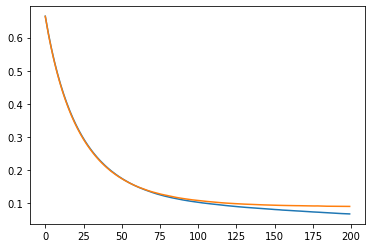

In [44]:
xgboost = gs.best_estimator_
eval_data = [(x_train, y_train), (x_test, y_test)]
xgboost.fit(x_train, y_train, eval_set=eval_data, verbose=0)
train_results = xgboost.evals_result()

# plot results
epochs = range(len(train_results['validation_0']['logloss']))
sns.lineplot(x=epochs, y=train_results['validation_0']['logloss'])
sns.lineplot(x=epochs, y=train_results['validation_1']['logloss'])

# Evaluate
y_hat = xgboost.predict(x_test)
print(classification_report(y_hat, y_test))

Above we can see the training process with our ideal hyperparameters. While it may seem like the performance of the model even decreased slightly, note how much closer together the training and test scores are. This model is not overfit, so it generalizes more reliably. Further, any decrease in metrics is very minimal.

## Feature Importance

<AxesSubplot:>

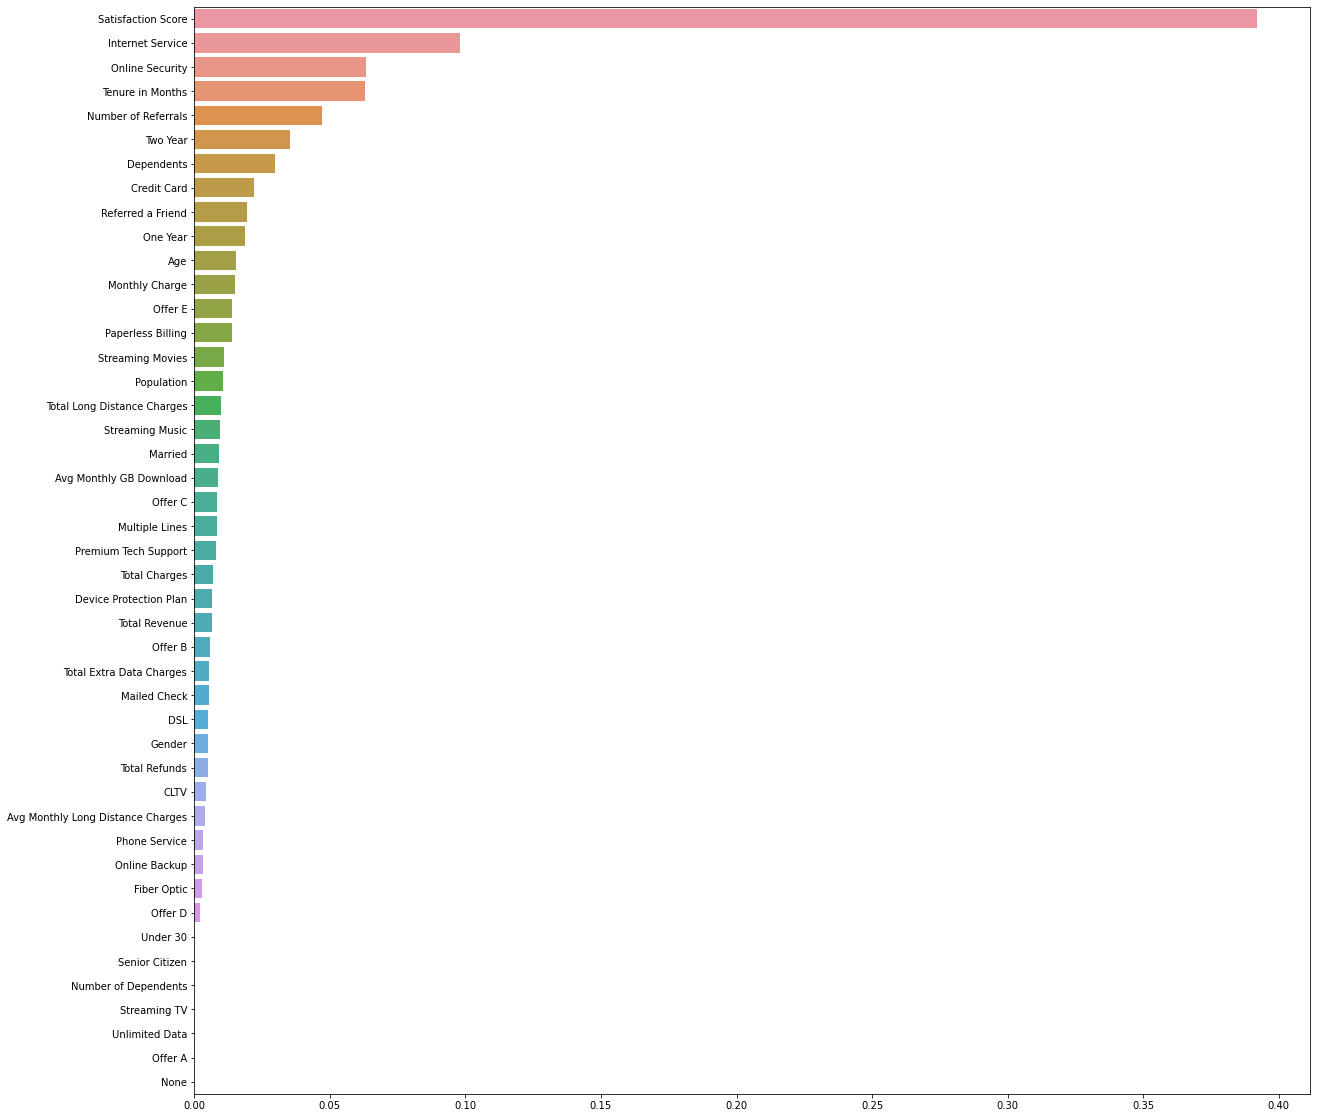

In [45]:
features_importances_labels = zip(xgboost.feature_importances_, df_cat_encode)
features_importances_labels = sorted(features_importances_labels, key=lambda x: x[0], reverse=True)
unzipped_feature_labels = list(zip(*features_importances_labels))
feature_importances = list(unzipped_feature_labels[0])
feature_labels = list(unzipped_feature_labels[1])

plt.figure(figsize=(20,20))
sns.barplot(y=feature_labels, x=feature_importances)


We can see from the above that the Satisfaction Score is far and away the most important feature for the model.